# CIFAR-10 image classification using a residual network (ResNet)

The goal is to classify a dataset of 32x32 color images into 10 classes using a custom ResNet neural network. We compare the performance of this network with a traditional convolutional network and a similar network wherein residual connections were replaced by skip connections. 

In [175]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange
from typing import Tuple

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)

from Trainer import ModelTrainer

In [26]:
# Directory to load/save datasets and models
data_dir = './datasets/'
if (not os.path.isdir(data_dir)):
    os.mkdir(data_dir)

model_dir = './models/'
if (not os.path.isdir(model_dir)):
    os.mkdir(model_dir)

# Directory for figures
fig_dir = './figures/'
if (not os.path.isdir(fig_dir)):
    os.mkdir(fig_dir)

# Device
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')

## Data preparation

In [27]:
# General image information
n_channels_in = 3  # Color images
pixel_size = 32
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
n_classes = len(classes)

# Composition of transforms for our dataset (PIL images)
# The last normalization step rescales using the mean and std of the data
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [transforms.Resize(pixel_size),  # Bilinear interpolation
     transforms.ToTensor(),  # Conversion to tensor (float conversion and 0-1 rescaling)
     transforms.Normalize(data_mean, data_std)]
)

In [28]:
# Loading MNIST dataset of handwritten digits
train_data = datasets.CIFAR10(data_dir,
                              train=True,
                              download=True,
                              transform=transform)
test_data = datasets.CIFAR10(data_dir,
                             train=False,
                             download=True,
                             transform=transform)

# Let us split the training set into train and validation sets
train_size = 0.9
n_samples_train = int(len(train_data)*train_size)
n_samples_val = len(train_data) - n_samples_train
train_data, val_data \
    = torch.utils.data.random_split(train_data,
                                    [n_samples_train, n_samples_val],
                                    generator=torch.Generator().manual_seed(42))

Files already downloaded and verified
Files already downloaded and verified


## Residual neural network (ResNet)

Using a deeper network, rather than a wider one, typically allows to mitigate overfitting for the same number of parameters (empirical observation). However, the fact that inputs are more spread-out throughout the network may lead to vanishing-gradient issues. Indeed, gradients are computed using back-propagation, accumulating the orders of magnitude of the network weights, which are typically lesser than unity. A similar problem arises in recurring neural network with weights lesser than unity.

Solutions to this issues are so-called "skip and residual" connections, which allow the output of some layer to skip a number of subsequent layers and combine it with the output of a much later hidden layer. The aforementioned connections can either add or concatenate outputs together. ResNets usually rely on addition connections, called "residual connections", which impose that the two connected layers share the same output size. Concatenation connections, called "skip connections", are typically used in densely connected convolutional networks (DenseNets).

This is a similar strategy to that implemented in long short-term memory (LSTM) networks to circumvent the gradient-vanishing/exploding problem. As in LSTM networks, "skip and residual" connections help information from the input penetrate deeper into the network.

Let us define our model, along with separate classes for the skip and residual blocks. For simplicity, we define blocks whose output size matches their input size. 

In [188]:
class ConvBlock(nn.Module):
    # Convolutional block with no residual connection
    def __init__(self, n_channels: int) -> None:
        super().__init__()

        # Activation function
        self.activation = nn.ReLU()

        # Convolutional and batch-norm layers
        conv_kernel_size = 3
        conv_stride = 1
        conv_padding = 1
        self.conv1 = nn.Conv2d(in_channels=n_channels,
                               out_channels=n_channels//2,
                               kernel_size=conv_kernel_size,
                               stride=conv_stride,
                               padding=conv_padding)
        self.bn1 = nn.BatchNorm2d(n_channels//2)    # Normalize batch per channel
                                                    # to mitigate internal covariate shift
        self.conv2 = nn.Conv2d(in_channels=n_channels//2,
                               out_channels=n_channels,
                               kernel_size=conv_kernel_size,
                               stride=conv_stride,
                               padding=conv_padding)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.activation(x)  # Activate first to later compare with ResBlock below
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return x


class ResBlock(nn.Module):
    # Convolutional block with simple identity residual connection
    def __init__(self, n_channels: int) -> None:
        super().__init__()

        # Activation function
        self.activation = nn.ReLU()

        # Convolutional and batch-norm layers
        conv_kernel_size = 3
        conv_stride = 1
        conv_padding = 1
        self.conv1 = nn.Conv2d(in_channels=n_channels,
                               out_channels=n_channels//2,
                               kernel_size=conv_kernel_size,
                               stride=conv_stride,
                               padding=conv_padding)
        self.bn1 = nn.BatchNorm2d(n_channels//2)    # Normalize batch per channel
                                                    # to mitigate internal covariate shift
        self.conv2 = nn.Conv2d(in_channels=n_channels//2,
                               out_channels=n_channels,
                               kernel_size=conv_kernel_size,
                               stride=conv_stride,
                               padding=conv_padding)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x0 = x  # Skip before activation
        x = self.activation(x)
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return x + x0  # Output addition


class SkipBlock(nn.Module):
    # Convolutional block with simple skip connection
    # Keep the output size equal to the input size if n_channels is even
    def __init__(self, n_channels: int) -> None:
        super().__init__()

        if n_channels % 2:  # Odd n_channels
            raise ValueError('n_channels should be even here, '
                             + 'to guarantee equal input and output sizes')

        # Activation function
        self.activation = nn.ReLU()

        # Convolutional and batch-norm layers
        conv_kernel_size = 3
        conv_stride = 1
        conv_padding = 1
        self.conv1 = nn.Conv2d(in_channels=n_channels,
                               out_channels=n_channels//2,
                               kernel_size=conv_kernel_size,
                               stride=conv_stride,
                               padding=conv_padding)
        self.bn1 = nn.BatchNorm2d(n_channels//2)
        self.conv2 = nn.Conv2d(in_channels=n_channels//2,
                               out_channels=n_channels//2,
                               kernel_size=conv_kernel_size,
                               stride=conv_stride,
                               padding=conv_padding)
    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.activation(self.conv1(x))

        x2 = self.activation(self.bn1(x1))
        x3 = self.conv2(x2)
        return torch.cat((x1, x3), 1)  # Output concatenation


def output_size_from_conv_pool(n_in: Tuple[int, int], conv_pool):
    kernel_size = conv_pool.kernel_size
    stride = conv_pool.stride
    dilation = conv_pool.dilation
    padding = conv_pool.padding

    if isinstance(kernel_size, tuple):
        n_out_0 = int(np.floor(
            (n_in[0] + 2*padding[0] - dilation[0]*(kernel_size[0] - 1) - 1)/stride[0] + 1))
        n_out_1 = int(np.floor(
            (n_in[1] + 2*padding[1] - dilation[1]*(kernel_size[1] - 1) - 1)/stride[1] + 1))
    else:
        n_out_0 = int(np.floor(
            (n_in[0] + 2*padding - dilation*(kernel_size - 1) - 1)/stride + 1))
        n_out_1 = n_out_0

    return (n_out_0, n_out_1)


class DeepNet(nn.Module):
    def __init__(self,
                 n_channels: int,
                 pixel_size: int,
                 n_hidden: int,
                 n_hidden_fc: int,
                 n_classes: int,
                 n_blocks: int = 2,
                 block_type = ResBlock,  # ConvBlock, ResBlock or SkipBlock
                 dropout: float = 0.5
                 ) -> None:
        super().__init__()

        # General architectural information
        self.activation = nn.ReLU()

        self.n_hidden = n_hidden

        conv_kernel_size = 3
        conv_stride = 1
        conv_padding = 1
        pool_kernel_size = 2

        # Max pooling layer
        self.pool = nn.MaxPool2d(pool_kernel_size)

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=n_channels,
                               out_channels=n_hidden,
                               kernel_size=conv_kernel_size,
                               stride=conv_stride,
                               padding=conv_padding)
        self.bn1 = nn.BatchNorm2d(n_hidden)

        self.conv2 = nn.Conv2d(in_channels=n_hidden,
                               out_channels=n_hidden,
                               kernel_size=conv_kernel_size,
                               stride=conv_stride,
                               padding=conv_padding)
        self.bn2 = nn.BatchNorm2d(n_hidden)

        self.conv3 = nn.Conv2d(in_channels=n_hidden,
                               out_channels=n_hidden,
                               kernel_size=conv_kernel_size,
                               stride=conv_stride,
                               padding=conv_padding)
        
        # nn.Sequential list of ResBlocks if n_blocks > 0
        self.n_blocks = n_blocks
        self.block_type = block_type
        if n_blocks > 0:
            self.layers = self.assemble_blocks()
        else:
            self.layers = nn.Identity()

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # What pixel_size becomes through the initial layers
        # To set the input size of the final fully connected layer
        output_size = (pixel_size, pixel_size)
        output_size = output_size_from_conv_pool(output_size, self.conv1)
        output_size = output_size_from_conv_pool(output_size, self.pool)
        output_size = output_size_from_conv_pool(output_size, self.conv2)
        output_size = output_size_from_conv_pool(output_size, self.pool)
        output_size = output_size_from_conv_pool(output_size, self.conv3)
        output_size = output_size_from_conv_pool(output_size, self.pool)
        output_size = output_size[0]
        
        if output_size <= 0:
            raise ValueError('output_size <= 0, check other dimensions to get output_size > 0')    
        
        n_outputs = n_hidden*output_size**2

        # Fully connected layers
        self.linear1 = nn.Linear(n_outputs, n_hidden_fc)
        self.linear2 = nn.Linear(n_hidden_fc, n_classes)

        # Initialize loggers
        self.train_loss_logger = []
        self.train_accuracy_logger = []
        self.val_accuracy_logger = []


    def assemble_blocks(self):
        # Put together residual or skip blocks into an nn.Sequential
        blocks = []
        for _ in range(self.n_blocks):
            blocks.append(self.block_type(self.n_hidden))
        return nn.Sequential(*blocks)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Initial convolutional/pooling layers to downsample feature maps
        # and get a reasonable number of parameters for final classification
        # (No activation on final output so that 
        #  the subsequent blocks are fed the raw output)
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.conv3(x)

        # Pass through blocks
        x = self.activation(self.layers(x))
        x = self.pool(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Dropout to mitigate overfitting
        x = self.dropout(x)

        # Fully connected layers
        x = self.activation(self.linear1(x))
        x = self.linear2(x)

        return x        

### Set up model and model trainer

One can actually define three types of model based on the `ConvBlock`, `ResBlock` and `SkipBlock` defined above. Only changing those blocks, let us call the resulting models `Customer_ConvNet`, `Customer_ResNet` and `Customer_SkipNet`.

In [217]:
# Define model
model_name = 'Custom_ResNet'
model = DeepNet(n_channels=n_channels_in,
                pixel_size=pixel_size,
                n_hidden=32,
                n_hidden_fc=32,
                n_classes=n_classes,
                n_blocks=6,
                block_type=ResBlock,
                dropout=0.5).to(device)

n_params = 0
for param in model.parameters():
    n_params += param.flatten().shape[0]
print(f'This model has {n_params} parameters')

This model has 92042 parameters


Whereas the `Customer_ConvNet` and `Customer_ResNet` networks have 92042 parameters, the `Customer_SkipNet` network has 78122 parameters (because the `SkipBlock` consists of modules with smaller hidden dimensions).

In [208]:
# Set up model trainer
batch_size = 128
n_epochs = 30
learning_rate = 1e-4
start_from_checkpoint = False

model_trainer = ModelTrainer(model=model,
                             device=device,
                             loss_fun=nn.CrossEntropyLoss(),
                             batch_size=batch_size,
                             learning_rate=learning_rate,
                             save_dir=model_dir,
                             model_name=model_name,
                             start_from_checkpoint=start_from_checkpoint)

# Set up data
model_trainer.set_data(train_set=train_data,
                       val_set=val_data,
                       test_set=test_data)

Starting from scratch
Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


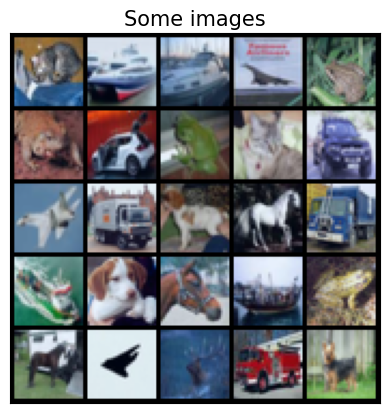

Ground-truth Labels:
['cat', 'ship', 'ship', 'plane', 'frog']
['frog', 'car', 'frog', 'cat', 'car']
['plane', 'truck', 'dog', 'horse', 'truck']
['ship', 'dog', 'horse', 'ship', 'frog']
['horse', 'plane', 'deer', 'truck', 'dog']


In [209]:
# Let us visualize a few images
images, labels = next(iter(model_trainer.test_loader))

n_row = 5
out = torchvision.utils.make_grid(images[:n_row**2], nrow=n_row, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.tick_params(axis='both',
                which='both',
                left=False,
                labelleft=False,
                bottom=False,
                labelbottom=False)
plt.title('Some images', fontsize=15)
plt.savefig(os.path.join(fig_dir, '1_some_images.png'),
            bbox_inches='tight', dpi=600)
plt.show()

print('Ground-truth Labels:')
classes_plot = [classes[i] for i in labels.numpy().astype(int)]
count = 0
for i in range(n_row):
    start_idx = n_row*i
    end_idx = start_idx + n_row
    print(classes_plot[start_idx:end_idx])

### Training and evaluation

In [ ]:
start_time = time.time()
progress_bar = trange(model_trainer.start_epoch, n_epochs, leave=False, desc='Epoch')

train_accuracy = 0.
val_accuracy = 0.
for epoch in progress_bar:
    # Append accuracy evaluations to progress bar
    progress_bar.set_postfix_str(f'Accuracy: Train={100*train_accuracy:.2f}%, Val={100*val_accuracy:.2f}%')

    # Train
    model_trainer.train_model()
    
    # Evaluate and log accuracy on training and validation sets
    train_accuracy = model_trainer.evaluate_model(train_test_val='train')
    val_accuracy = model_trainer.evaluate_model(train_test_val='val')

    # Save model if current validation accuracy is greater than the previous best
    if val_accuracy > model_trainer.best_valid_acc:
        model_trainer.save_checkpoint(epoch, val_accuracy)
end_time = time.time()

In [211]:
print(f'Highest validation accuracy: {100*model_trainer.best_valid_acc:.2f}%')
print(f'Training time: {(end_time - start_time):.2f} seconds')

Highest validation accuracy: 73.30%
Training time: 443.84 seconds


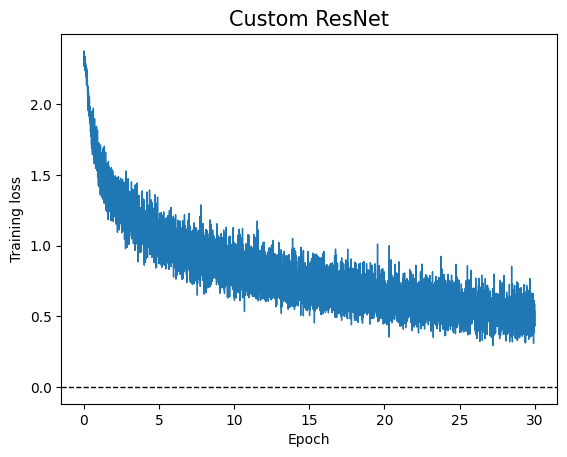

In [212]:
x_epoch = np.linspace(0, n_epochs, len(model_trainer.train_loss_logger))
plt.axhline(y=0, ls='--', color='k', lw=1)
plt.plot(x_epoch, model_trainer.train_loss_logger, lw=1)

xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title(model_name.replace('_', ' '), fontsize=15)
plt.savefig(os.path.join(fig_dir, '2_training_loss_' + model_name + '.png'),
            bbox_inches='tight', dpi=600)
plt.show()

The training loss is rather noisy, as one would expect when using mini-batch gradient descent with a rather small batch size.

Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

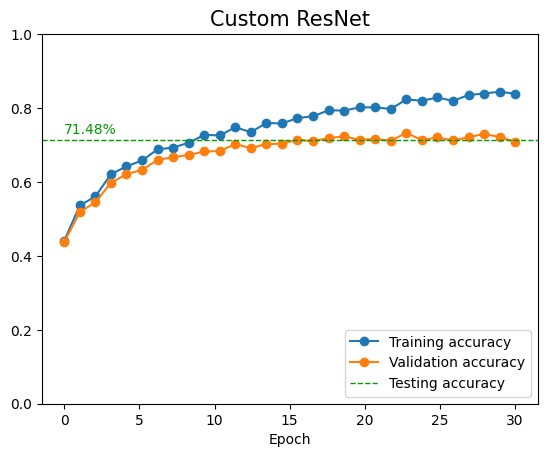

In [213]:
x_epoch = np.linspace(0, n_epochs, len(model_trainer.train_acc_logger))
plt.plot(x_epoch, model_trainer.train_acc_logger, marker='o', label='Training accuracy')

x_epoch = np.linspace(0, n_epochs, len(model_trainer.val_acc_logger))
plt.plot(x_epoch, model_trainer.val_acc_logger, marker='o', label='Validation accuracy')

testing_accuracy = model_trainer.evaluate_model(train_test_val='test')
plt.axhline(y=testing_accuracy, color=[0, 0.6, 0], ls='--', lw=1, label='Testing accuracy')
plt.text(0, 1.01*testing_accuracy, f'{100*testing_accuracy:.2f}%', color=[0, 0.6, 0], va='bottom')

plt.ylim([0, 1])
xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.title(model_name.replace('_', ' '), fontsize=15)
plt.savefig(os.path.join(fig_dir, '3_training_validation_accuracy_' + model_name + '.png'),
            bbox_inches='tight', dpi=600)
plt.show()

The training accuracy overshoots the validation accuracy, which indicates some overfitting.

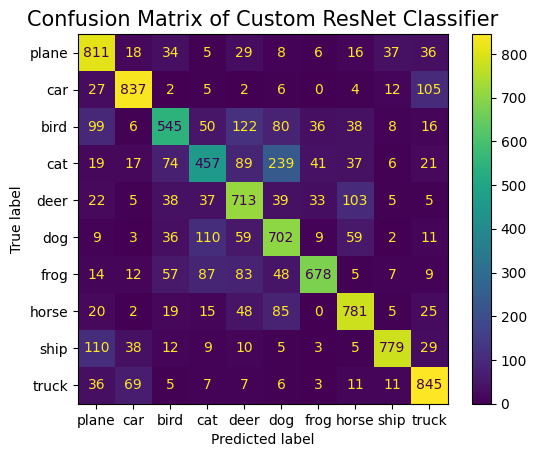

In [214]:
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in model_trainer.test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)

        # max returns (output_value, index)
        predictions = outputs.argmax(1)

        all_predictions.append(predictions.cpu().numpy().tolist())
        all_labels.append(labels.cpu().numpy().tolist())
    
# Flatten predictions and labels
all_predictions = [x for item in all_predictions for x in item]
all_labels = [x for item in all_labels for x in item]

confusion_mat = confusion_matrix(y_true=all_labels, y_pred=all_predictions)
disp = ConfusionMatrixDisplay(confusion_mat, display_labels=classes)
disp.plot()
plt.title('Confusion Matrix of ' + model_name.replace('_', ' ') + ' Classifier', fontsize=15)
plt.savefig(os.path.join(fig_dir, '4_confusion_matrix_' + model_name + '.png'),
            bbox_inches='tight', dpi=600)
plt.show()

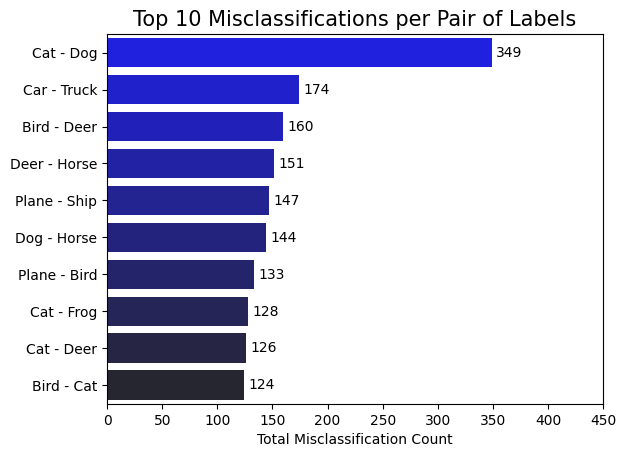

In [215]:
# Most prevalent misclassifications
class_labels = np.arange(n_classes)
miscl = []
for i in range(n_classes-1):
    for j in range(i+1, n_classes):
        count = confusion_mat[i, j] + confusion_mat[j, i]
        miscl.append([i, j, count])

miscl = np.array(miscl)
miscl = miscl[miscl[:, -1].argsort()[::-1]]

n_plot = 10

sns.barplot(x=miscl[:(n_plot), -1], y=np.arange(n_plot), orient='h',
            hue=np.arange(n_plot), palette='dark:b_r', legend=False)
ylabels = [f'{classes[miscl[i, 0]].capitalize()} - {classes[miscl[i, 1]].capitalize()}' for i in range(n_plot)]

for idx, val in enumerate(miscl[:(n_plot), -1]):
    plt.text(val+4, idx, f'{val}', va='center')

plt.gca().set_yticks(plt.gca().get_yticks())  # To suppress a warning
plt.gca().set_yticklabels(ylabels)
plt.title(f'Top {n_plot} Misclassifications per Pair of Labels', fontsize=15)
plt.xlabel('Total Misclassification Count')
plt.xlim([0, 450])
plt.savefig(os.path.join(fig_dir, '5_misclassification_count_' + model_name + '.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- The `Custom_ConvNet` classifier has reached an accuracy of 65.18%.
- The `Custom_SkipNet` classifier has reached an accuracy of 69.38%.
    - Better than `Custom_ConvNet` despite its fewer parameters.
- The `Custom_ResNet` classifier has reached an accuracy of 71.48%.
    - This corresponds to 6.3% more accuracy than `Custom_ConvNet` and 2.1% more accuracy than `Custom_SkipNet`.
- All networks present some degree of overfitting.
    - `Custom_ConvNet` has the most overfitting.
    - Overfitting is mitigated in `Custom_ResNet` and `Custom_SkipNet`, with `Custom_SkipNet` having the lowest overfitting, potentially due to its fewer parameters.
- The cat and dog labels are the most likely labels to be misclassified as each other.